In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import pickle

matplotlib.style.use('ggplot')

np.random.seed(1234)

import astropy.stats as astropy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
X0 = pickle.load(open('tmp_X0.dat','r'))
X1 = pickle.load(open('tmp_X1.dat','r'))

In [21]:
X0.shape

(5000, 1)

In [94]:
bins_n = 30
eps = 0.1
t_min = max(0, min(np.min(X0), np.min(X1)) - eps)
t_max = min(1, max(np.max(X0), np.max(X1)) + eps)
range = [(t_min, t_max)]
reals2 = np.linspace(0, 1, 500)
normed = False

In [160]:
def overflowbins(h,e):
    h = np.insert(h, 0, 0., axis=0)
    h = np.insert(h, h.shape[0], 0., axis=0)
    e[0] = np.insert(e[0], 0, -np.inf)
    e[0] = np.insert(e[0], len(e[0]), np.inf)
    return h,e

def pdf(X,h,e):
    all_indices = []
    indices = np.searchsorted(e[0],
                              X[:, 0],
                              side="right") - 1

    # For the last bin, the upper is inclusive
    indices[X[:, 0] == e[0][-2]] -= 1
    all_indices.append(indices)

    return h[all_indices]

import pdb

def density(h,e):
    #bins = [0.] + e + [1.]
    bins = e
    widths = bins[1:] - bins[:-1]
    norm_h = h / widths / h.sum()
    return norm_h
    

In [163]:
h0, e0 = np.histogramdd(X0, bins=bins_n, range=range,normed=True) 
h1, e1 = np.histogramdd(X1, bins=bins_n, range=range,normed=True) 
h0,e0 = overflowbins(h0,e0)
h1,e1 = overflowbins(h1,e1)
# Under-overflow bins

In [164]:
# Using same count bins
N = 15 # number of bins
splits = np.array_split(np.sort(X0.ravel()), N)
print(len(splits))
print(X0.shape[0])
base = [splits[0][0]] + [x[-1] for x in splits]
base = np.array(base)
bins = base
h0_b, e0_b = np.histogram(X0.ravel(), bins=bins, range=(0.,1.),normed=normed)
h0_b = density(h0_b, e0_b)
e0_b = [e0_b]

splits = np.array_split(np.sort(X1.ravel()), N)
base = [splits[0][0]] + [x[-1] for x in splits]
base = np.array(base)
bins = base #da, bins = astropy.scott_bin_width(X.ravel(), True)
h1_b, e1_b = np.histogram(X1.ravel(), bins=bins, range=(0.,1.), normed=normed)
h1_b = density(h1_b, e1_b)
e1_b = [e1_b]

h0_b,e0_b = overflowbins(h0_b,e0_b)
h1_b,e1_b = overflowbins(h1_b,e1_b)

15
5000


In [134]:

bins = astropy.bayesian_blocks(X0.ravel(), fitness='events',p0=0.9)
#print(bins)
#da, bins = astropy.scott_bin_width(X.ravel(), True)
h0_b, e0_b = np.histogram(X0.ravel(), bins=bins, range=range[0],normed=normed)

e0_b = [e0_b]
bins = astropy.bayesian_blocks(X1.ravel(), fitness='events',p0=0.9)
#da, bins = astropy.scott_bin_width(X.ravel(), True)
h1_b, e1_b = np.histogram(X1.ravel(), bins=bins, range=range[0],normed=normed)
e1_b = [e1_b]

h0_b,e0_b = overflowbins(h0_b,e0_b)
h1_b,e1_b = overflowbins(h1_b,e1_b)
print(h0_b)

[  0  35  77  16  17   4  11  42 242  13  81  17   3 118 133  93 163 133
  10  51   9  19  62   2  84   5 188 140   2  14  69   3  59   8 142   4
  18   5 493   6 107   3  98  95  16  12  88  31  73  23  41  17  13  72
  20   8  14  39  18   3  12   3  11  20   7  10   2  18  30   3  16   5
  23   9  17  10   5  14   9  16  10  21   6  17   4   8 212  31  33  28
 126   3  90   3  95   1 101   2  76   2  88   4 106   6  48   2  54   1
  57   3  57   1  31   4  26  21   0]


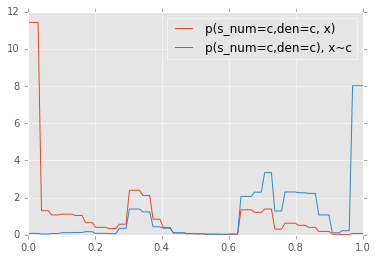

In [168]:
reals2 = np.linspace(0, 1, 100)

plt.plot(reals2, pdf(reals2.reshape(-1, 1),h0,e0), 
         label="p(s_num=c,den=c, x)")
plt.plot(reals2, pdf(reals2.reshape(-1, 1),h1,e1), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()

[  0.00000000e+00   2.17365778e-01   8.61164708e-01   2.23137901e-01
   2.71711695e+00   2.89207768e+00   2.43493716e+00   2.39115082e+00
   2.11372742e+00   2.01002476e+00   1.92441706e+00   7.55639820e-01
   2.52788386e+00   5.93363383e+01   9.61893717e+03   3.30481861e+02
   0.00000000e+00]
[array([       -inf,  0.00785203,  0.314248  ,  0.39181736,  0.66250199,
        0.68900067,  0.70290071,  0.73296309,  0.7666707 ,  0.78483766,
        0.82304615,  0.86222684,  0.97206753,  0.99841368,  0.9995361 ,
        0.99953789,  0.99988949,         inf], dtype=float32)]


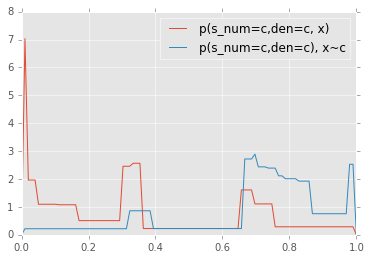

In [169]:
print(h1_b)
print(e1_b)
#print(reals2)
plt.plot(reals2, pdf(reals2.reshape(-1, 1),h0_b,e0_b), 
         label="p(s_num=c,den=c, x)")
plt.plot(reals2, pdf(reals2.reshape(-1, 1),h1_b,e1_b), 
        label="p(s_num=c,den=c), x~c")
plt.legend()
plt.show()

In [170]:
print(h1)
print(e1)

[ 0.          0.078       0.042       0.066       0.11399998  0.12600001
  0.16800001  0.078       0.06599997  0.34800002  1.38600008  1.23000007
  0.43200003  0.35400002  0.10800001  0.06        0.06599994  0.02400002
  0.02999997  0.04200004  2.06399828  2.29200219  3.34199721  1.27800122
  2.30399808  2.26200216  2.22599814  1.06800102  0.10799991  0.22200021
  8.01599331  0.        ]
[array([       -inf,  0.        ,  0.03333334,  0.06666667,  0.1       ,
        0.13333334,  0.16666667,  0.2       ,  0.23333333,  0.26666668,
        0.30000001,  0.33333334,  0.36666667,  0.40000001,  0.43333334,
        0.46666667,  0.5       ,  0.53333336,  0.56666666,  0.60000002,
        0.63333333,  0.66666669,  0.69999999,  0.73333335,  0.76666665,
        0.80000001,  0.83333331,  0.86666667,  0.89999998,  0.93333334,
        0.96666664,  1.        ,         inf], dtype=float32)]


In [171]:
print(h1_b)
print(e1_b)

[  0.00000000e+00   2.17365778e-01   8.61164708e-01   2.23137901e-01
   2.71711695e+00   2.89207768e+00   2.43493716e+00   2.39115082e+00
   2.11372742e+00   2.01002476e+00   1.92441706e+00   7.55639820e-01
   2.52788386e+00   5.93363383e+01   9.61893717e+03   3.30481861e+02
   0.00000000e+00]
[array([       -inf,  0.00785203,  0.314248  ,  0.39181736,  0.66250199,
        0.68900067,  0.70290071,  0.73296309,  0.7666707 ,  0.78483766,
        0.82304615,  0.86222684,  0.97206753,  0.99841368,  0.9995361 ,
        0.99953789,  0.99988949,         inf], dtype=float32)]


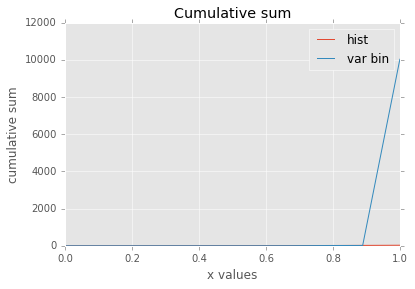

In [172]:
x = np.linspace(0.,1.,10)
cum1 = [h1[:np.argmin(e1[0] < k)].sum() for k in x]
cum1_b = [h1_b[:np.argmin(e1_b[0] < k)].sum() for k in x]
plt.plot(x,cum1,label='hist')
plt.plot(x,cum1_b,label='var bin')
plt.legend()
plt.title('Cumulative sum')
plt.ylabel('cumulative sum')
plt.xlabel('x values')

In [50]:
h1_b[np.argmin(e1_b[0] < 0.8):].sum()

2315